In [10]:
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import EarlyStopping

import matplotlib.pyplot as plt



In [78]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


DATASET_ROOT = './dataset/'
BATCH_SIZE = 64;
NUM_CLASS = 7;

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    
    transforms.RandomHorizontalFlip(0.4),
#     transforms.Normalize([0.5], [0.5])
    
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
])

data_transforms = {'train': train_transform, 'test': test_transform}


datasets = {x : ImageFolder(DATASET_ROOT + x, transform=data_transforms[x]) for x in ['train', 'test']}

dataloaders = {x : (DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=12) if x == 'train' else DataLoader(datasets[x], batch_size=BATCH_SIZE)) for x in ['train', 'test']}





torch.Size([1, 48, 48])


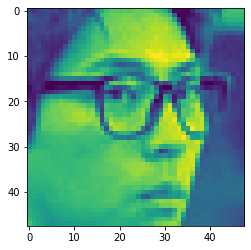

In [79]:
sample_img = datasets['test'][6][0]
print(sample_img.shape)

plt.imshow(sample_img.permute(1,2,0))

In [80]:

class EmotiClassifier(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        
        self.learning_rate = learning_rate;
        self.batch_size = 64;
        
        self.accuracy = torchmetrics.Accuracy()
        
        self.l1 = nn.Sequential(
            
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            nn.Conv2d(32,64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            
            
            nn.Conv2d(64,128, 3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            nn.Conv2d(128,256, 3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
        )
        
#         self.l2 = nn.Sequential(
#             nn.Conv2d(128, 64, 5),
#             nn.ReLU(),
#             nn.Conv2d(64, 32, 5),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 16, 5),
#             nn.ReLU(),
            
#             nn.Conv2d(16, 8, 5),
#             nn.ReLU(),
#         )
        
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
        )
        
        
        self.loss = nn.CrossEntropyLoss();
        
    def conv_out_shape(self, x):
        return self.l1(x).view(x.shape[0], -1).shape
#         return self.l2(self.l1(x)).view(x.shape[0], -1).shape

        
    
    def forward(self, x):
        out = self.l1(x);
        out = out.view(-1, 256);
        out = self.fc(out);
        
        return out
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch;
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        
        return loss;
    
    def validation_step(self, batch, batch_idx):
        x, y = batch;
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        self.accuracy(y_hat, y)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', self.accuracy, prog_bar=True, on_epoch=True)
        return loss
        
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-5);
        return optimizer;


In [81]:
model = EmotiClassifier(0.001);
# for x,y in dataloaders['train']:
#     print(model.conv_out_shape(x));
#     break;

In [82]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    strict=False,
    verbose=False,
    mode='min',
)


trainer = pl.Trainer(auto_lr_find=True, progress_bar_refresh_rate=20, gpus=1, max_epochs=200)

# trainer.tune(model, dataloaders['train'], dataloaders['test'])


trainer.fit(model, dataloaders['train'], dataloaders['test'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | Accuracy         | 0     
1 | l1       | Sequential       | 388 K 
2 | fc       | Sequential       | 43.5 K
3 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.729     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## EfficientNet Experiment

In [83]:
torch.save(model.state_dict(), './emoticlassifier-64acc-1_250loss.pth')

In [4]:
from torchvision.models import efficientnet_b0


class EmotiEff(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        
        self.feature_extractor = efficientnet_b0(weights=True)
        self.feature_extractor.classifier[1] = nn.Linear(1280, 7, bias=True);
        self.feature_extractor.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        
        self.learning_rate = learning_rate;
        self.batch_size = 64;
        
        self.accuracy = torchmetrics.Accuracy();
        
        
        
        self.loss = nn.CrossEntropyLoss();
        
    def conv_out_shape(self, x):
        return self.l2(self.l1(x)).view(x.shape[0], -1).shape
        
        
    
    def forward(self, x):
        out = self.feature_extractor(x);
        return out
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch;
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        
        return loss;
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch;
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.accuracy(y_hat, y)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_accuracy', self.accuracy, prog_bar=True, on_epoch=True);
        return loss
        
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate);
        return optimizer;


In [8]:
model2 = EmotiEff(0.01)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    strict=False,
    verbose=False,
    mode='min',
)

trainer2 = pl.Trainer(callbacks=[early_stop], progress_bar_refresh_rate=20, gpus=1, max_epochs=200);
trainer2.fit(model2, dataloaders['train'], dataloaders['test'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | EfficientNet     | 4.0 M 
1 | accuracy          | Accuracy         | 0     
2 | loss              | CrossEntropyLoss | 0     
-------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.064    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [7]:
torch.save(model2.state_dict(), './emoticlassifier-61acc-1_140loss.pth')

## Resnet Experiment

In [ ]:
from torchvision.models import resnet50

class EmotiRes(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        
        self.feature_extractor = resnet50(weights="IMAGENET1K_V2");
        
        
        self.feature_extractor.linear = nn.Linear(2048, 7, bias=True);        
        self.feature_extractor.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        
        
        self.learning_rate = learning_rate;
        self.batch_size = 64;
        
        self.accuracy = torchmetrics.Accuracy();
        
        
        
        self.loss = nn.CrossEntropyLoss();
        
    def conv_out_shape(self, x):
        return self.l2(self.l1(x)).view(x.shape[0], -1).shape
        
        
    
    def forward(self, x):
        out = self.feature_extractor(x);
        return out
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch;
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        
        return loss;
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch;
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.accuracy(y_hat, y)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_accuracy', self.accuracy, prog_bar=True, on_epoch=True);
        return loss
        
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate);
        return optimizer;

In [ ]:
model3 = EmotiRes(0.001)
print(model3)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    strict=False,
    verbose=False,
    mode='min',
)
trainer3 = pl.Trainer(progress_bar_refresh_rate=20, max_epochs=200, gpus=1, callbacks=[early_stop]);
trainer3.fit(model3, dataloaders['train'], dataloaders['test'])

In [ ]:
import gradio as gr
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')


tr = transforms.Compose([
    transforms.Normalize([0.5], [0.5])
            
])

predictor = EmotiEff(0.001)

labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

predictor.load_state_dict(torch.load('emoticlassifier-62acc.pth'))

def classify(image):
    
    cv2_image = np.moveaxis(image, 1, 0)
    cv2_image = cv2_image[:, :, np.newaxis]
    print(cv2_image.shape)
    cv2.imshow('hello', cv2_image)
    
    image = torch.Tensor(image)
    image = image.view(1, 1, image.shape[0], image.shape[1])
    image = tr(image);
    
    
    pred = predictor(image)
    
    label = torch.argmax(pred)
    
    pred_class = label.item()

    return labels[pred_class]

webcam = gr.Image(source='webcam', streaming=True, shape=(150, 150), image_mode='L')

interface = gr.Interface(fn=classify, inputs=webcam, outputs='text')

In [ ]:
interface.launch()